In [14]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tifffile as tiff
from scipy.signal.windows import triang
from keras.models import load_model
import torch
import torch.nn as nn


In [8]:
# Define base path for all operations
BASE_PATH = os.getcwd()
BASE_PATH

'/home/gadmicha/Regression'

In [9]:
all_organelles = ["Nucleolus-(Granular-Component)", "Nuclear-envelope", "Mitochondria", "Actin-filaments",
                 "Endoplasmic-reticulum", "Plasma-membrane", "Microtubules", "DNA"]

In [10]:
# Variable Paths
organelle = all_organelles[1]
unet_model_path = f"{BASE_PATH}/ISL_Models/Unet/{organelle}/"
mg_model_path = f"{BASE_PATH}/ISL_Models/MG/{organelle}/"
conf_model_path = f"{BASE_PATH}/ISL/experiments_Mask_Pred/{organelle}/best_lr_1e-05_batch_size_16_optimizer_adam_weight_decay_0.01_use_batchnorm_True_use_dropout_False/model.pt"
test_csv_path = f"/sise/assafzar-group/assafzar/full_cells_fovs/train_test_list/{organelle}/image_list_test.csv"

In [11]:
# Load neccessary models
unet = load_model(unet_model_path)
mg = load_model(mg_model_path)

In [12]:
from torchvision.models.video import r3d_18

class ResNet3DRegression(nn.Module):
    def __init__(self, fine_tune_layers='partial'):
        super(ResNet3DRegression, self).__init__()
        # Load pretrained 3D ResNet
        self.resnet3d = r3d_18(pretrained=True)
        
        # Adjust the first convolutional layer for single-channel input
        self.resnet3d.stem[0] = nn.Conv3d(
            in_channels=2,
            out_channels=64,
            kernel_size=(3, 7, 7),
            stride=(1, 2, 2),
            padding=(1, 3, 3),
            bias=False
        )
        
        self.resnet3d.fc = nn.Identity()  # Remove the classification head

        # Fully connected layers for regression
        self.fc1 = nn.Linear(512, 128)  # ResNet3D outputs 512 features
        self.fc2 = nn.Linear(128, 1)

        # Fine-tuning options
        if fine_tune_layers == 'fc_only':  # Train only fc1 and fc2
            for param in self.resnet3d.parameters():
                param.requires_grad = False
        elif fine_tune_layers == 'partial':  # Train fc1, fc2, and later layers (e.g., layer4)
            for name, param in self.resnet3d.named_parameters():
                if 'layer4' in name or 'fc' in name:
                    param.requires_grad = True
                else:
                    param.requires_grad = False
        elif fine_tune_layers == 'full':  # Train all layers
            for param in self.resnet3d.parameters():
                param.requires_grad = True

    def forward(self, x):
        x = self.resnet3d(x)  # Pass through 3D ResNet
        x = torch.relu(self.fc1(x))  # Fully connected layer 1
        # x = torch.nn.functional.softplus(self.fc2(x))  # Output layer
        x = torch.relu(self.fc2(x))  # Output layer
        return x


In [17]:
%%capture

# Load confidence model
conf_model = ResNet3DRegression(fine_tune_layers='partial')
conf_model.load_state_dict(torch.load(conf_model_path, weights_only=True))
conf_model.eval()

In [18]:
def normalize_std(input_image):
    # Ensure input is a numpy array and convert to float64 for precision
    input_image = np.array(input_image, dtype=np.float64)
    
    # Calculate mean and standard deviation
    mean = np.mean(input_image)
    std = np.std(input_image)

    if (np.isnan(mean) or np.isnan(std) or np.isinf(mean) or np.isinf(std)):
        max_val = np.max(input_image[np.isfinite(input_image)])
        input_image = np.where(input_image==np.inf, max_val, input_image)
        mean = np.mean(input_image,dtype=np.float64)
        std = np.std(input_image,dtype=np.float64)
    
    # Check and adjust standard deviation to avoid division by zero
    if std == 0:
        std = 1  # Prevent division by zero; alternatively could use a very small number
    
    # Normalize the image
    normalized_image = (input_image - mean) / std
    
    # Replace NaN values that might result from zero divisions or infinite values in input
    normalized_image = np.nan_to_num(normalized_image, nan=0.0)
    
    return normalized_image

In [19]:
def get_weights(shape):
    """Generate a 3D triangular weighting mask for smooth patch blending."""
    shape_in = shape  # e.g., (1, 32, 128, 128, 1)
    shape = shape[1:-1]  # (D, H, W)
    
    # Start with ones of the right shape
    weights = np.ones(shape)
    
    for dim, size in enumerate(shape):
        axis_weights = triang(size)
        # Reshape axis_weights to broadcast across full shape
        reshape_dims = [1] * len(shape)
        reshape_dims[dim] = size
        axis_weights = axis_weights.reshape(reshape_dims)
        
        weights *= axis_weights  # Proper broadcasting multiplication

    # Add batch and channel dimensions back
    weights = weights[np.newaxis, ..., np.newaxis]  # shape: (1, D, H, W, 1)
    return weights.astype(np.float32)


def compute_padding(img_dim, patch_size, stride):
    full_coverage = ((img_dim - patch_size) + stride - 1) // stride * stride + patch_size
    total_pad = full_coverage - img_dim
    pad_before = total_pad // 2
    pad_after = total_pad - pad_before
    return pad_before, pad_after


In [20]:
test_csv = pd.read_csv(test_csv_path)
for path in test_csv['path_tiff']:
    print(path)

/sise/assafzar-group/assafzar/full_cells_fovs/Nuclear-envelope/Nuclear-envelope_2.tiff
/sise/assafzar-group/assafzar/full_cells_fovs/Nuclear-envelope/Nuclear-envelope_23.tiff
/sise/assafzar-group/assafzar/full_cells_fovs/Nuclear-envelope/Nuclear-envelope_103.tiff
/sise/assafzar-group/assafzar/full_cells_fovs/Nuclear-envelope/Nuclear-envelope_99.tiff
/sise/assafzar-group/assafzar/full_cells_fovs/Nuclear-envelope/Nuclear-envelope_116.tiff
/sise/assafzar-group/assafzar/full_cells_fovs/Nuclear-envelope/Nuclear-envelope_87.tiff
/sise/assafzar-group/assafzar/full_cells_fovs/Nuclear-envelope/Nuclear-envelope_74.tiff
/sise/assafzar-group/assafzar/full_cells_fovs/Nuclear-envelope/Nuclear-envelope_121.tiff
/sise/assafzar-group/assafzar/full_cells_fovs/Nuclear-envelope/Nuclear-envelope_140.tiff
/sise/assafzar-group/assafzar/full_cells_fovs/Nuclear-envelope/Nuclear-envelope_20.tiff
/sise/assafzar-group/assafzar/full_cells_fovs/Nuclear-envelope/Nuclear-envelope_71.tiff
/sise/assafzar-group/assafzar

In [21]:
# Load image
path = "/sise/assafzar-group/assafzar/full_cells_fovs/Plasma-membrane/Plasma-membrane_23.tiff"
image = tiff.imread(path)
image_num = path.split('.')[0].split('_')[-1]


In [22]:
input_image = image[0, :, :, :]
Z, X, Y = input_image.shape

target_image = image[3, :, :, :]

input_image = normalize_std(input_image)


In [23]:
# Patch settings
patch_size = [32, 128, 128]
stride_z = 16
stride_xy = 32

In [24]:
# Compute padding
pad_z = compute_padding(Z, patch_size[0], stride_z)
pad_x = compute_padding(X, patch_size[1], stride_xy)
pad_y = compute_padding(Y, patch_size[2], stride_xy)

# Pad input and target symmetrically
input_padded = np.pad(input_image, (pad_z, pad_x, pad_y), mode='reflect')
target_padded = np.pad(target_image, (pad_z, pad_x, pad_y), mode='reflect')

# Update dimensions for loop
Z_pad, X_pad, Y_pad = input_padded.shape

In [25]:
# Initialize output volumes
prediction = np.zeros_like(input_padded)
importance_map = np.zeros_like(input_padded)
confidence_map = np.zeros_like(input_padded)
weight_sum = np.zeros_like(input_padded) + 1e-4

In [ ]:
# Slide over the full volume with overlap
start = time.time()

for i in range(0, Z_pad - patch_size[0] + 1, stride_z):
    for j in range(0, X_pad - patch_size[1] + 1, stride_xy):
        for k in range(0, Y_pad - patch_size[2] + 1, stride_xy):
            # Slice patch
            patch_input = input_padded[i:i+patch_size[0], j:j+patch_size[1], k:k+patch_size[2]]
            patch_target = target_padded[i:i+patch_size[0], j:j+patch_size[1], k:k+patch_size[2]]

            # Prepare for models (N, D, H, W, C)
            patch_input_tensor = np.expand_dims(patch_input, axis=(0, -1))  # shape: (1, D, H, W, 1)
            patch_target_tensor = np.expand_dims(patch_target, axis=(0, -1))  # shape: (1, D, H, W, 1)

            # ISL prediction
            patch_prediction = unet(patch_input_tensor)  # shape: (1, D, H, W, 1)

            # Importance mask
            patch_mask = mg.generator([patch_input_tensor, patch_prediction]).numpy()  # shape: (1, D, H, W, 1)

            # Combine for confidence model
            patch_combined = np.concatenate([patch_prediction, patch_mask], axis=-1)  # (1, D, H, W, 2)
            patch_combined = torch.from_numpy(patch_combined).float().permute(0, 4, 1, 2, 3)  # (1, 2, D, H, W)

            patch_confidence = conf_model(patch_combined)  # shape: (1, 1)

            # Get weights and accumulate predictions
            weights = get_weights(patch_prediction.shape)  # shape: (1, D, H, W, 1)
            patch_prediction_np = patch_prediction[0, ..., 0]  # Remove batch/channel → (D, H, W)
            patch_mask_np = patch_mask[0, ..., 0]  # shape: (D, H, W)

            # Broadcast scalar confidence value to patch shape
            confidence_patch = np.full_like(patch_prediction_np, patch_confidence.item())

            # Accumulate weighted predictions
            prediction[i:i+patch_size[0], j:j+patch_size[1], k:k+patch_size[2]] += patch_prediction_np * weights[0, ..., 0]
            importance_map[i:i+patch_size[0], j:j+patch_size[1], k:k+patch_size[2]] += patch_mask_np * weights[0, ..., 0]
            confidence_map[i:i+patch_size[0], j:j+patch_size[1], k:k+patch_size[2]] += confidence_patch * weights[0, ..., 0]
            weight_sum[i:i+patch_size[0], j:j+patch_size[1], k:k+patch_size[2]] += weights[0, ..., 0]

end = time.time()
print(f"Sliding window inference took {end - start:.2f} seconds.")


In [ ]:
# Normalize final maps
prediction = prediction / weight_sum
importance_map = importance_map / weight_sum
confidence_map = confidence_map / weight_sum

In [ ]:
# Crop back to original shape
z0, z1 = pad_z[0], Z_pad - pad_z[1]
x0, x1 = pad_x[0], X_pad - pad_x[1]
y0, y1 = pad_y[0], Y_pad - pad_y[1]


In [ ]:
prediction = prediction[z0:z1, x0:x1, y0:y1]
importance_map = importance_map[z0:z1, x0:x1, y0:y1]
confidence_map = confidence_map[z0:z1, x0:x1, y0:y1]


In [ ]:
# Stack into one (3, Z, X, Y) array
stack = np.stack([prediction, importance_map, confidence_map], axis=0)
tiff.imwrite(f"{BASE_PATH}/Inference/{organelle}/image_{image_num}_inference_outputs.tiff", stack.astype(np.float32))

In [27]:
# Threshold dictionary for mask interpreter
ths = {}
ths[all_organelles[0]] = 0.6
ths[all_organelles[1]] = 0.2
ths[all_organelles[2]] = 0.2
ths[all_organelles[3]] = 0.2
ths[all_organelles[4]] = 0.4
ths[all_organelles[5]] = 0.4
ths[all_organelles[6]] = 0.1

In [28]:
image_num = 116

# Load the 4D array: (3, Z, X, Y)
stack = tiff.imread(f"{BASE_PATH}/Inference/{organelle}/image_{image_num}_inference_outputs.tiff")

# Unpack channels
prediction = stack[0]
importance_map = stack[1]
confidence_map = stack[2]

# Load target
target = tiff.imread(f"/sise/assafzar-group/assafzar/full_cells_fovs/{organelle}/{organelle}_{image_num}.tiff")[3,:,:,:]


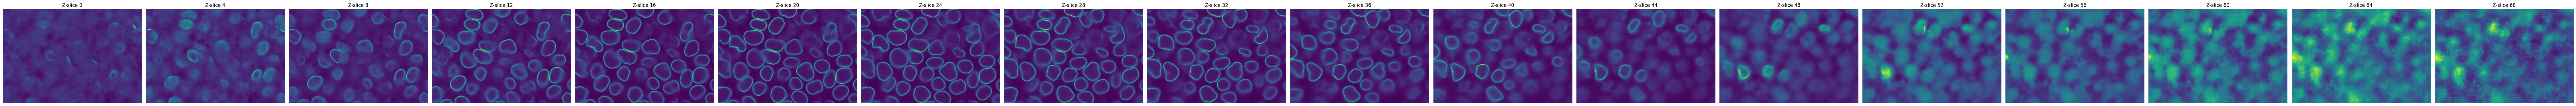

In [29]:
# Plot z-slices to see which is best
def plot_slices(image, step=4, cmap="viridis"):
    z_slices = image.shape[0]
    selected_slices = range(0, z_slices, step)
    
    # Create subplots dynamically based on the number of slices
    num_slices = len(selected_slices)
    fig, axes = plt.subplots(1, num_slices, figsize=(5 * num_slices, 5))  # Adjust figure size
    
    # Ensure axes is iterable, even for one slice
    if num_slices == 1:
        axes = [axes]
    
    # Loop through and plot every 4th Z-slice
    for i, z in enumerate(selected_slices):
        ax = axes[i]
        ax.imshow(image[z,:,:], cmap=cmap)
        ax.set_title(f'Z-slice {z}')
        ax.axis('off')  # Turn off axes for cleaner visualization
    
    # Adjust layout
    plt.tight_layout()
    plt.show()

plot_slices(prediction)

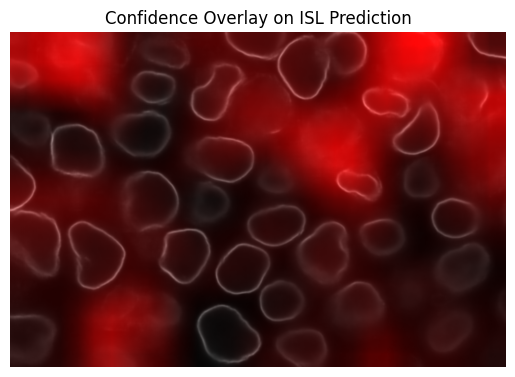

In [30]:
z_slice = prediction.shape[0] // 2  # or any slice you'd like

# Normalize prediction slice to [0, 1]
pred_slice = prediction[z_slice]
pred_norm = (pred_slice - pred_slice.min()) / (pred_slice.ptp() + 1e-8)

# Build grayscale RGB background and darken it slightly for contrast
pred_rgb = np.stack([pred_norm] * 3, axis=-1)

# Normalize confidence slice to [0, 1]
conf_slice = confidence_map[z_slice]
conf_norm = (conf_slice - conf_slice.min()) / (conf_slice.ptp() + 1e-8)

# Build confidence overlay channel
conf_overlay = np.zeros_like(pred_rgb)
conf_overlay[..., 0] = conf_norm * 2 # red channel

# Blend
alpha = 0.5
blended = (1 - alpha) * pred_rgb + alpha * conf_overlay
blended = np.clip(blended, 0.0, 1.0).astype(np.float32)

# Display
plt.imshow(blended)
plt.axis("off")
plt.title(f"Confidence Overlay on ISL Prediction")
# plt.savefig(f"{BASE_PATH}/Regression/Outputs/{organelle} heatmap.png", bbox_inches='tight')
plt.show()

Text(0.5, 1.0, 'Bright-Field Image for ISL Prediction (Z=35)')

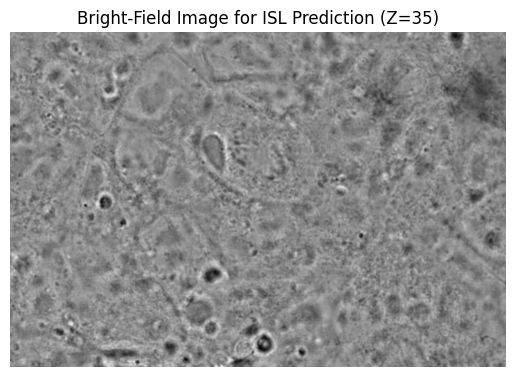

In [31]:
plt.imshow(input_image[z_slice].astype(np.float32), cmap='gray')
plt.axis('off')
plt.title(f"Bright-Field Image for ISL Prediction (Z={z_slice})")

Text(0.5, 1.0, 'ISL Prediction (Z=35)')

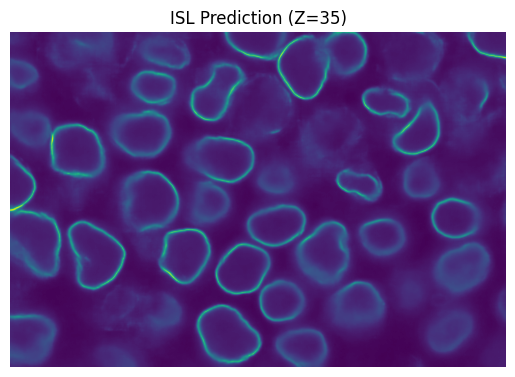

In [32]:
plt.imshow(prediction[z_slice].astype(np.float32))
plt.axis('off')
plt.title(f"ISL Prediction (Z={z_slice})")

Text(0.5, 1.0, 'Ground Truth for ISL Prediction (Z=35)')

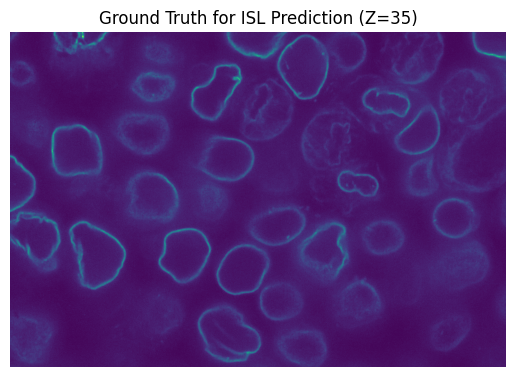

In [33]:
plt.imshow(target[z_slice].astype(np.float32))
plt.axis('off')
plt.title(f"Ground Truth for ISL Prediction (Z={z_slice})")

In [34]:
target_slice_norm = (target[z_slice] - target[z_slice].min()) / (target[z_slice].ptp() + 1e-8)
prediction_slice_norm = (prediction[z_slice] - prediction[z_slice].min()) / (prediction[z_slice].ptp() + 1e-8)
target_prediction_diff = target_slice_norm - prediction_slice_norm
prediction_target_diff = prediction_slice_norm - target_slice_norm

Text(0.5, 1.0, 'Ground Truth Minus Prediction (Z=35)')

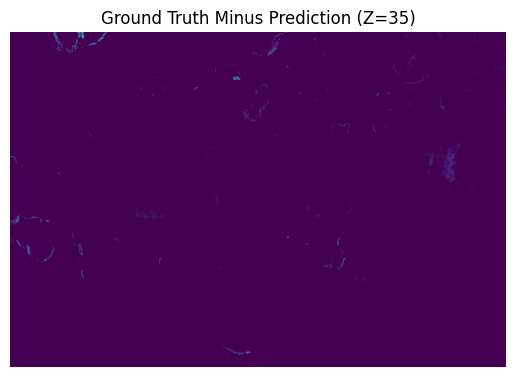

In [35]:
plt.imshow(target_prediction_diff.astype(np.float32), vmin=0.05)
plt.axis('off')
plt.title(f"Ground Truth Minus Prediction (Z={z_slice})")

Text(0.5, 1.0, 'Prediction Minus Ground Truth (Z=35)')

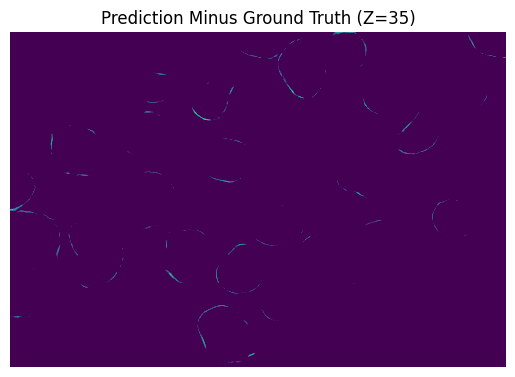

In [36]:
plt.imshow(prediction_target_diff.astype(np.float32), vmin=0.3)
plt.axis('off')
plt.title(f"Prediction Minus Ground Truth (Z={z_slice})")

Text(0.5, 1.0, 'Mask Interpreter Explanation (Z=35)')

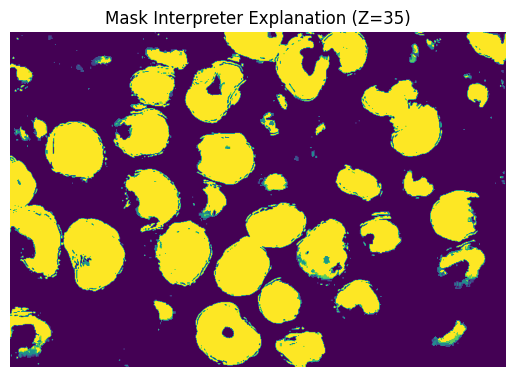

In [37]:
binary = importance_map > ths[organelle]
plt.imshow(binary[z_slice].astype(np.float32))
plt.axis('off')
plt.title(f"Mask Interpreter Explanation (Z={z_slice})")

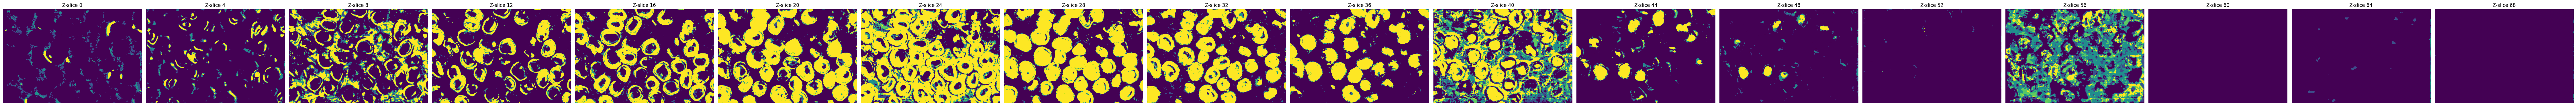

In [38]:
plot_slices(binary)

In [39]:
## Patch steps
xy_step = 64
z_step = 16

def calculate_spatial_pcc(image1,image2):
    # Compute the Pearson correlation coefficient matrix for each slice of the 3D images
    corr_matrix = np.zeros((image1.shape[0], image1.shape[1], image1.shape[2]))
    occur_matrix = np.zeros((image1.shape[0], image1.shape[1], image1.shape[2]))
    for z in range(image1.shape[0]):
        for i in range(0,image1.shape[1] - xy_step + 1,z_step):
            for j in range(0,image1.shape[2] - xy_step + 1,z_step):
                corr_matrix[z,i:i+xy_step, j:j+xy_step] += np.corrcoef(image1[z,i:i+xy_step, j:j+xy_step].flatten(), image2[z,i:i+xy_step, j:j+xy_step].flatten())[0, 1]
                occur_matrix[z,i:i+xy_step, j:j+xy_step] +=1.0
    return (corr_matrix/occur_matrix).astype(np.float16)    

pcc_map = calculate_spatial_pcc(target, prediction)

/tmp/ipykernel_402998/3342857056.py:14: RuntimeWarning: invalid value encountered in divide
  return (corr_matrix/occur_matrix).astype(np.float16)


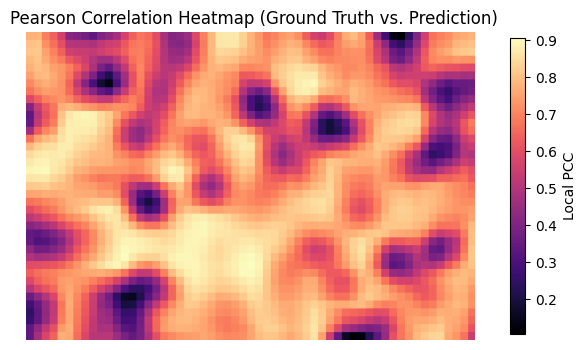

In [41]:
# plot
plt.figure(figsize=(6, 4))
plt.axis('off')
im = plt.imshow(pcc_map[z_slice], cmap="magma")
plt.colorbar(im, shrink=0.8, label="Local PCC")
plt.title("Pearson Correlation Heatmap (Ground Truth vs. Prediction)")
plt.tight_layout()
plt.show()

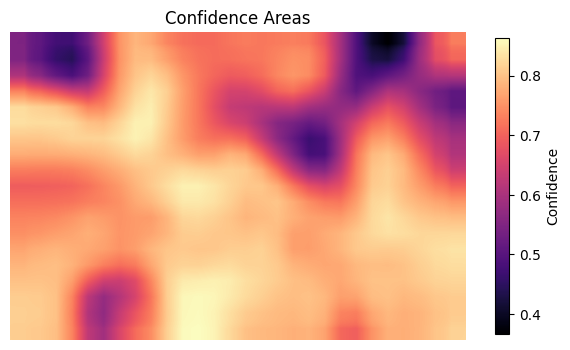

In [42]:
plt.figure(figsize=(6, 4))
plt.axis('off')
im = plt.imshow(1-confidence_map[z_slice], cmap="magma")
plt.colorbar(im, shrink=0.8, label="Confidence")
plt.title("Confidence Areas")
plt.tight_layout()
plt.show()